In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

jobs = pd.read_pickle(r'Notebooks/jeff-jobs-cleaned-2025.pkl')
supply = pd.read_pickle(r'Notebooks/jeff-supply-cleaned-2025.pkl')

# Relationship Between Hours Worked and Days Elapsed
<pre>
There is no linear relationship. 

This tells that days_elapsed likely has little to do with the difficulty of the job.
Could focus efforts into delays that cause a job to go unfinished.

Are these jobs being forgotten about, waiting on supplies, simply deemed unimportant? There are many possibities,
but I find this lack of a relationship notable. 
<pre>

In [6]:
filtered_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['hours_worked_flag'] != True) & (jobs['days_elapsed'].notna())] #23311 records 

filtered_jobs['days_elapsed'].corr(filtered_jobs['total_hours_worked']).round(4) #-0.0565

#Note: Also tried with days_elapsed < 100, got correlation = 0.05

-0.0565

# Hours Worked By Equipment Nomenclature

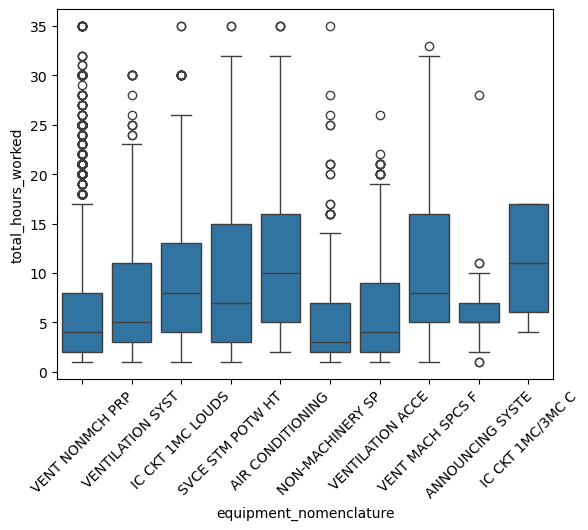

In [7]:
top10 = filtered_jobs['equipment_nomenclature'].value_counts().nlargest(10).index
df_top10 = filtered_jobs[filtered_jobs['equipment_nomenclature'].isin(top10)]

sns.boxplot(x='equipment_nomenclature', y='total_hours_worked', data = df_top10)
plt.xticks(rotation = 45)
plt.show()
#All have at least 188 records
#Shows some sign of relationship between equipment being worked on and # of hours required to complete MA 


In [8]:
#Simple Linear Regression Using Equipment Nomenclature to Predict total_hours_worked
df_top10.loc[:,'equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')
model = ols('total_hours_worked ~ C(equipment_nomenclature)', data = df_top10).fit()
#model.rsquared = .045

#ANOVA
#Null: No differences between the means of individuals groups
#H1: Difference between at least 2 groups means
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                  sum_sq       df          F         PR(>F)
C(equipment_nomenclature)   27644.521118      9.0  84.332587  7.283757e-154
Residual                   584328.031302  16043.0        NaN            NaN


C:\Users\carswje\AppData\Local\Temp\ipykernel_32676\1422143295.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', ..., 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP', 'VENT NONMCH PRP']
Length: 16053
Categories (10, string): [AIR CONDITIONING, ANNOUNCING SYSTE, IC CKT 1MC LOUDS, IC CKT 1MC/3MC C, ..., VENT MACH SPCS F, VENT NONMCH PRP, VENTILATION ACCE, VENTILATION SYST]' has dtype incompatible with string, please explicitly cast to a compatible dtype first.
  df_top10.loc[:,'equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')


<pre>
Very little predictive power using equipment_nomenclature to predict total_hours_worked
<pre>

# Relationship between when discovered, cause, deferral reason and days_elapsed

In [9]:
model = ols('days_elapsed ~ C(cause_code) + C(when_discovered_code) + C(deferral_reason_code)', data = jobs).fit()
result = model.summary() #R2 = 0.134
#print(result)
#also considered fitting with filtered_jobs, make a difference of .001 to r2

# Priority 
<pre>
Desirable: 46737
Highly desirable: 503
Essential: 95
Mandatory: 15

Most records in this dataset refer to MAs where it is not urgent to be completed quickly.
<pre>

# Number of Jobs Opened by Month for CVN 74

Text(0.5, 1.0, 'Jobs Opened By Month On CVN 74')

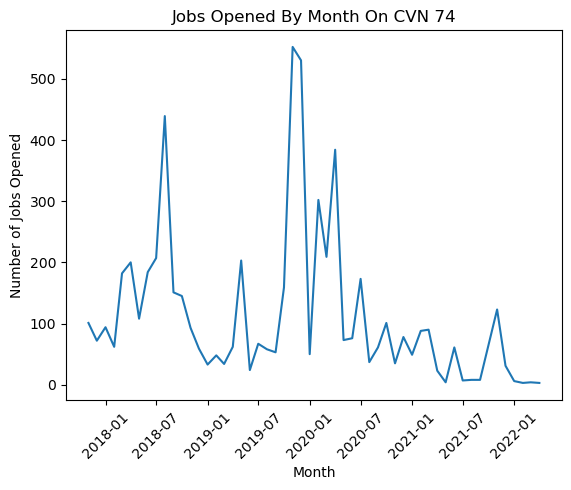

In [10]:
cvn74 = jobs[jobs['ship'] == 'CVN74'] 

monthly_counts = cvn74.groupby(cvn74['date_maintenance_action'].dt.to_period('M')).size() #Number of jobs opened each month on CVN74

monthly_counts.index = monthly_counts.index.to_timestamp() #Handles TypeError: float() argument must be a string or a real number, not 'Period'

plt.plot(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel("Number of Jobs Opened")
plt.title("Jobs Opened By Month On CVN 74")

<pre>
There appears to be some meaningful variation from month to month.
Could look into trends/changes during busier or slower times
Specifically, do jobs take longer to complete during busier times?
<pre>

In [11]:
#Ideas Related to Time and The Number of Jobs Being Worked On Over Time


#Add variable showing # of jobs going on at the beginning of the MA 
#Add variable showing # of jobs that occur with the interval of the MA (date_maintenance_action ---> date_closing)
#For these variables, need to look at the job's ship. Also could look to subset further to work_center

# Next Ideas
<pre>
Predict when_discovered, cause, or deferral_reason
Cases for Each:

deferral_reason: Relatively balanced variable
Knowing why jobs get deferred in advance could help forecast for given types of jobs.
As specific personnel and work centers have specialties, additional information about why a job most often gets pushed back could help personnel plan. 
For example, knowing that a type of job often gets delayed for lack of material could lead to more effort towards montoring supply counts.


cause: Knowing the cause for a type of MA can help us enhance efforts in these areas. 
Cons: 'Normal wear and tear' and 'Other' make up the majority of the records for this variable. 

when_discovered: 
Relatively balanced 
Also, the top 2 most frequent are insightful - Normal operation and during inspection


Predict Engineered Variable: Binary, supplies required (Y/N)

Predict Engineered Variable: Job Took Longer than 8 hours to Complete (Y/N)
<pre>

# Idea: Predict deferral_reason
<pre>
Variables that Could Be Meaningful Predictors:

ship
cause_code
csmp_narrative_summary, equipment_nomenclature
location
priority_code, safety_code, status_code, component_status
when_discovered_code
work_center 
def_narrative, nondef_narrative
type_of_availability_needed


Number of jobs open at that time: One level is Due to ships' force work backlog
<pre>

# Ideas for Enhancing Text Features
<pre>
equipment_nomenclature, csmp_narrative_summary: Vectorization and then grouping most similar entries. Idea: reduce categories from >2100 to ~ 100
def_narrative
<pre>

# Plotting The Distribution for Hours Worked

0.311

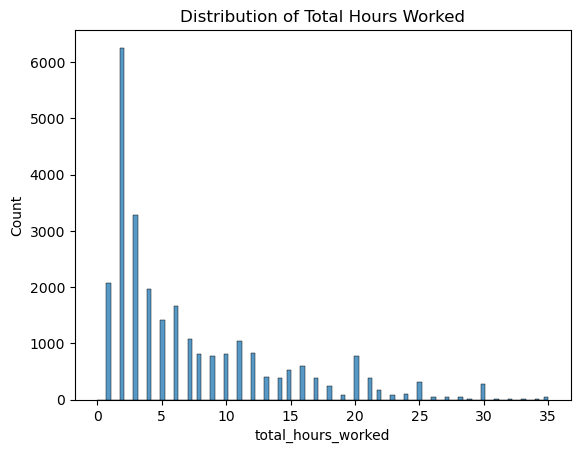

In [12]:
traditional_jobs = jobs[(jobs['hours_worked_flag'] != True) & (jobs['job_status'] != 'Open')]  #~ 27k records
#Only consider closed jobs that did not have outlier hours worked
sns.histplot(data=traditional_jobs, x='total_hours_worked', bins=100)
plt.title("Distribution of Total Hours Worked")

#Most jobs only take a few hours

#Considering jobs that did not have outlier hours worked, 31.1% of jobs took more than 8 hours to complete
(traditional_jobs['total_hours_worked'] > 8).mean().round(3)

# Plotting the Distribution of Days Elapsed

0.631

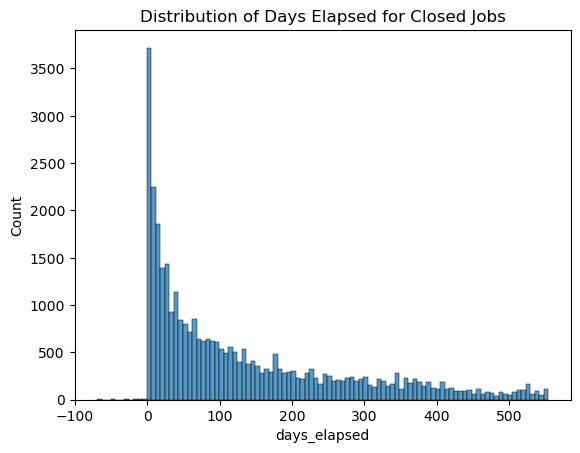

In [13]:
closed_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['job_status'] != 'Open')]  #~ 38k records

#Only consider closed jobs that were completed
sns.histplot(data=closed_jobs, x='days_elapsed', bins=100)
plt.title("Distribution of Days Elapsed for Closed Jobs")

(closed_jobs['days_elapsed'] > 30).mean().round(3) #55% of closed jobs took more than 50 days to complete
#76% of closed jobs took more than 10 days to complete

# Takeaway
<pre>
63% of closed jobs take over 30 days to become closed. This is when we remove days_elapsed outliers and only consider Closed jobs.
However, less than a third of the jobs take more than 8 hours (a full work day) to complete.

We could also see from the plots that there is a discrepency between the number of days elapsed and the total number of hours worked.

Also, deferral_reason_code:
35% due to lack of material
24% due to ship's force work backlog/operational priority
14% other/NA
13% lack of facilities/ capabiltiies
10% For ship's force overhaul

It seems that a bulk of the time spent for jobs to be closed is due to supply wait time or operational backlog.

Factors likely influencing operational backlog: Number of concurrent jobs being worked on
Factors likely influencing supply wait time: The types of parts being ordered, the quantity of parts, where parts are being ordered from, when the parts are ordered. 

<pre>

# -------------------------------Supply EDA------------------------------------

# Relationship between Supply Days Waiting and Total Days Elapsed

In [14]:
#There are multiple part orders associated with a job. We should look at the part order that takes the longest to complete, making the assumption
#that a job cannot be completed until all parts have been received. 

In [2]:
supply_sub = supply[(supply['valid_dates'] == True) & (supply['supply_days_waiting_outlier'] == False)]
supply_sub = supply_sub[['job_seq','date_maintenance_action','demand_date','issue_date','date_closing','supply_days_waiting']]

supply_sub['total_days'] = supply_sub['date_closing'] - supply_sub['date_maintenance_action']
supply_sub['total_days'] = supply_sub['total_days'].dt.days

supply_sub['total_days'].corr(supply_sub['supply_days_waiting']).round(3)

0.238

# Plotting Supply Wait Time Vs. Total Job Time For Records With Only One Part Order

0.315

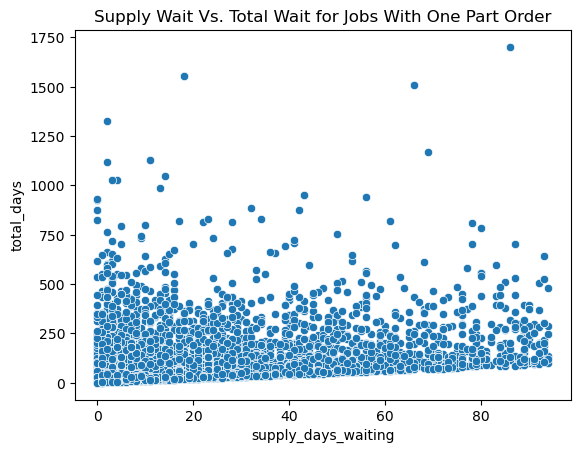

In [3]:
# Lets look only at rows where job_seq is present once. 
#see if there is any relationship

#having multiple part orders associated with a job will add noise. Will look at jobs with multiple part orders later

#if any sign of a relationship, could look into group by operations to look at jobs with multiple part orders

unique_jobs = supply_sub['job_seq'].value_counts()
unique_jobs = unique_jobs[unique_jobs == 1].index

supply_unique = supply_sub[supply_sub['job_seq'].isin(unique_jobs)] #7174 records

sns.scatterplot(x = 'supply_days_waiting', y = 'total_days', data = supply_unique)
plt.title('Supply Wait Vs. Total Wait for Jobs With One Part Order')

supply_unique['supply_days_waiting'].corr(supply_unique['total_days']).round(3) #0.315

# Hypothetical: Assume Total Days > 100 is a Misinput

0.561

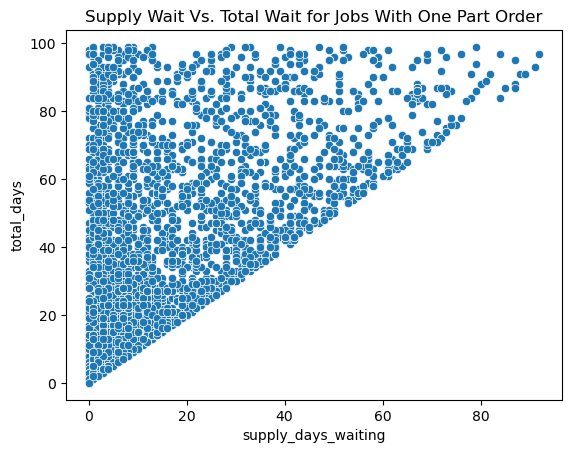

In [4]:
unique_jobs = supply_sub['job_seq'].value_counts()
unique_jobs = unique_jobs[unique_jobs == 1].index

supply_unique = supply_sub[(supply_sub['job_seq'].isin(unique_jobs)) & (supply_sub['total_days'] < 100)]

sns.scatterplot(x = 'supply_days_waiting', y = 'total_days', data = supply_unique)
plt.title('Supply Wait Vs. Total Wait for Jobs With One Part Order')

supply_unique['supply_days_waiting'].corr(supply_unique['total_days']).round(3) #0.561 
#dataset is 4998 records 

<pre>
Saw some relationship, so now:
<pre>

# Looking at All Records (More than 1 Part Order)

<pre>
I will assume that a job cannot begin until all parts are received
Look at the earliest demand date and the latest issue date
<pre>

In [5]:
all_parts = supply_sub.groupby('job_seq').agg({
    'demand_date': 'min',
    'issue_date': 'max'
})
all_parts['all_part_wait'] = (all_parts['issue_date'] - all_parts['demand_date']).dt.days

all_parts.rename(columns = {'demand_date': 'first_demand_date', 'issue_date': 'last_issue_date'}, inplace = True)
#Now, need to join with supply_sub to have total days waiting too


<pre>
Notes: 

supply_sub has all those columns with repeating job_seq
all_parts has unique job_seq

left join
all_parts as left table

since date_maintenance_action and date_closing never differ in supply_sub,
can drop duplicates and keep the time a job_seq occurs
<pre>

In [6]:
supply_sub_unique = supply_sub.drop_duplicates(subset = 'job_seq', keep = 'first') #11572 rows

supply_sub_unique = supply_sub_unique[['job_seq','total_days','date_maintenance_action','date_closing']]

Text(0.5, 1.0, 'Supply Wait Vs. Total Wait for All Jobs')

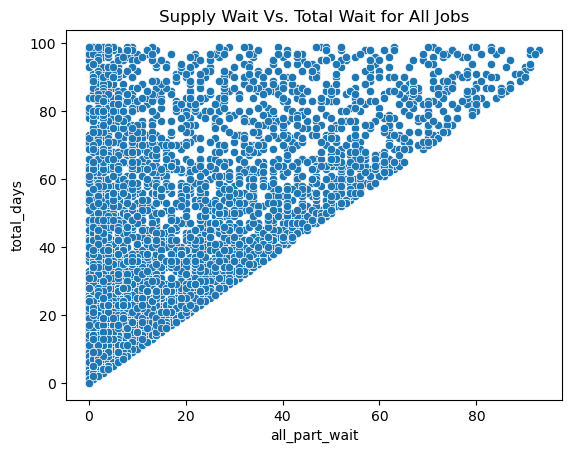

In [7]:
dat = pd.merge(supply_sub_unique, all_parts, how = 'left', on = 'job_seq') #Merged data
#Contains job_seq, all_part_wait, total_days

dat = dat[ (dat['total_days'] < 100)] #exclude records with > 100 days open as these feel like outliers (could use or not use this depending on goals)


dat['all_part_wait'].corr(dat['total_days']).round(3) #.603. Increased from when only looking at one part jobs.
#Not too meaningful, makes sense because the time from min date_maintenance_action to max date_closing will naturally capture more 
#variation occuring.
#7.7k records

sns.scatterplot(x = 'all_part_wait', y = 'total_days', data = dat)
plt.title('Supply Wait Vs. Total Wait for All Jobs')

# Takeaways:
<pre>
Knowing supply wait time does not provide too much value for knowing total wait time. 
This is also true for hours worked when looking for key contributors to time open. 

I believe there could be some pretty significant flaws in closing out jobs properly in the system. 
If neither hours worked or supply wait time are meaningful signals, something is likely to be off from my perspective. 

If there are no errors and the logging is mostly accurate, it could be that jobs are being forgotten about. 

This could be a key insight. It could be possible that jobs are being completed later than initially intended because they were simply forgotten about/
lost in the worklog. 
<pre>

# Next Ideas
<pre>
Idea 1: Look at lifecycle of job and see which contributes most to days_open

    Could look at # of days between date_maintenance_action and issue_date to see if any unnecessary delays
    Could look at # of days between issue_date and date_closing. 
    See which of these 3 intervals most contributes to full days open
    *Consider including and excluding days_open > 100. Note differences when looking at each.




Idea 2: Look at supply_days_waiting by source_code (feels like this should be meaningful) 
    If noticable differences, could see which factors most influence source_code

            Could investigate other features as well such as niin_nomenclature, ship, issue_apl, issue_eic, unit_of_issue


Idea 3: Compare differences in times waiting between part orders associated with the same job_seq. Inter vs. intra group differences

Idea 4: Pivot away from days open related analysis. Look into comparing jobs that do and do/not require supply orders
    *See if there is a notable difference in the types of jobs that require supply orders and those that do not


Idea 5: Group similar types of jobs and reccomend parts based on past similar jobs. NLP likely needed here to extract info from free form columns
    Notify personnel: Parts likely to be required, parts likely to be ordered before beginning job


Idea 6: Could create a job difficulty metric: # of hours worked, # of parts needed, # of days expected to be open (if others show signal)
<pre>

# ----------------- Idea 1: Lifecylce of Maintenance Actions -----------------

In [21]:
dat.shape #Reminder for Later: 14330 unique job seq -> 14142 (supply cleaned-remove NA niin) -> 11572 (valid dates and supply days waiting outlier flags)
# -> 7.7k (total days open < 100)
#goes from 11.5k to 7.7k when removing jobs with days open > 100.

(7700, 7)

In [22]:
dat['start_to_demand_days'] = (dat['first_demand_date'] - dat['date_maintenance_action']).dt.days
dat = dat.rename(columns = {'all_part_wait': 'demand_to_issue_days'}) #rename all_part_wait for consistent variable name formatting
dat['issue_to_close_days'] = (dat['date_closing'] - dat['last_issue_date']).dt.days

In [23]:
#reorder columns for logical flow
dat = dat[['job_seq','date_maintenance_action','start_to_demand_days','first_demand_date',
           'demand_to_issue_days','last_issue_date','issue_to_close_days','date_closing','total_days']]

Boxplot for each of the three
Proportion of total time (divide by total days)
correlation between the different durations and total job time

# Adding Feature: Proportions of Total Time Elapsed

In [24]:
dat['prop_stage1'] = ((dat['start_to_demand_days'] / dat['total_days']) *100).round(1)
dat['prop_stage2'] = ((dat['demand_to_issue_days'] / dat['total_days']) * 100).round(1)
dat['prop_stage3'] = ((dat['issue_to_close_days'] / dat['total_days']) * 100).round(1)

dat[['prop_stage1','prop_stage2','prop_stage3']] = dat[['prop_stage1','prop_stage2','prop_stage3']].fillna(0) #NAs created by div by 0 (total_days = 0)

# Considering Relationships Between Stages

In [25]:
corr_matrix = dat[['start_to_demand_days','demand_to_issue_days','issue_to_close_days','total_days']].corr().round(2)

corr_pairs = (corr_matrix
              .where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
              .stack().reset_index()
              )
corr_pairs = corr_pairs.sort_values(by = 0, ascending = False)

corr_pairs.columns = ['Variable 1', 'Variable 2', 'Corr']
print(corr_pairs) #Displays correlation between variables in descending order of correlation

             Variable 1            Variable 2  Corr
5   issue_to_close_days            total_days  0.71
4  demand_to_issue_days            total_days  0.60
2  start_to_demand_days            total_days  0.26
3  demand_to_issue_days   issue_to_close_days -0.03
0  start_to_demand_days  demand_to_issue_days -0.05
1  start_to_demand_days   issue_to_close_days -0.06


<pre>
Takeaways:
 
- A possible bottleneck exists between the time the parts are received and the time to complete the MA.
    - This could be caused by lack of awareness that parts have arrived, foregetfullness, 
      or simply improper closing of MAs in the system (jobs are not actually taking this long). 
    - One reccomendation could be: Notifications sent to personnel that parts have arrived, so that operations are not delayed longer than necessary. 


- Parts are being ordered in a reasonable amount of time, and not contributing much to overall delays. 

- The amount of time taken for one stage does not have any connection with the amount of time taken for another stage when considering 
subparts of the MA. Stages 1,2,3 of the MA: None of these combinations have any meaningful linear relationship


# Distributions For Each Stage

In [26]:
cols = ['start_to_demand_days','demand_to_issue_days','issue_to_close_days']

#melt dataframe for seaborn boxplot
dat_melted = dat[cols].melt(var_name = 'Stage',value_name = 'Days')

Text(0.5, 1.0, 'Maintenance Job Time By Stage')

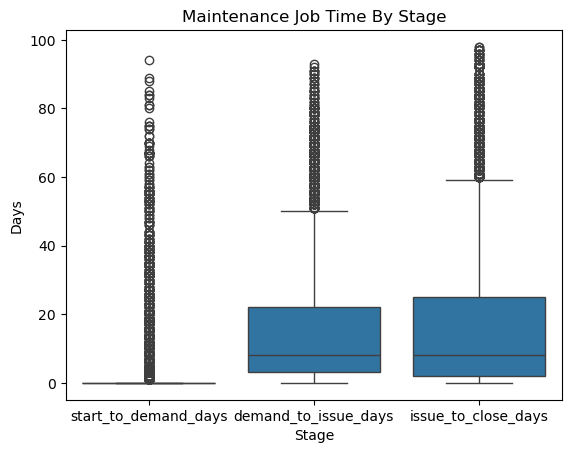

In [27]:
sns.boxplot(x = 'Stage', y = 'Days', data = dat_melted)
plt.title("Maintenance Job Time By Stage")

<pre>
Takeaway: 

Most wait time is due to demand_to_issue and issue_to_close stages. 
issue_to_close days has the most variance and contributes slightly more than demand_to_issue to overal days waiting. 

# Saving Job Time Breakdown Breakdown Data For Future Reference

In [28]:
dat.to_pickle('Notebooks/work_breakdown.pkl') #contains start -> first demand date, first demand date -> last issue date, last issue date -> close date
#7.7k x 12